# 🩻 BratsMamba: 3D Brain Tumor Segmentation with State Space Model

---

Content : 

- Problem Statement
- Clinical Context
- The Challenge
- Solution Overview
- Key Technical Features
- Referred Sources(Research Papers, Codebases)

### 🔵 **Problem Statement**

Our main goal is to capture both fine-grained tumor boundaries (Necrosis) and global contextual features (Edema) efficiently in MRI tumor images. This is a heavily researched and critical area vital for bio-medical engineering field. This problem is in the domain of computer vision, specifically semantic segmentation tasks. 

Semantic segmentation is a critical task in computer vision, requiring the precise classification of every pixel in an image. Traditional Convolutional Neural Networks (CNNs) like U-Net excel at capturing local features but often struggle with long-range dependencies due to their limited receptive fields. Transformers addressed this with self-attention, but at the cost of quadratic computational complexity($O(N^2)$), making them heavy for high-resolution tasks.

### 🟣 **Clinical Context**

Gliomas are the most common primary brain malignancies. Treatment planning (surgery and radiotherapy) relies heavily on the precise delineation of tumor sub-regions:
1.  **Necrotic Core (NCR):** Dead tissue, indicates tumor aggressiveness.
2.  **Peritumoral Edema (ED):** Swelling around the tumor, critical for radiotherapy margins.
3.  **Enhancing Tumor (ET):** Active tumor cells, the primary target for surgical resection.

### 🟡 **The Challenge**

Manual segmentation by radiologists is tedious, time-consuming (hours per patient), and prone to inter-observer variability. An automated, accurate 3D segmentation tool can:
*   **Accelerate Diagnosis:** Reduce analysis time from hours to seconds.
*   **Standardize Care:** Provide consistent, objective measurements for longitudinal tracking.
*   **Surgical Planning:** Enable precise 3D mapping for neuro-navigation systems to preserve healthy brain tissue.


### 🟢 **Solution Overview**

We use a hybrid architecture that leverages the strengths of both `CNNs` and `State Space Models (SSMs)` to efficiently capture both local and global features in MRI images.

**Why Mamba?** We address this trade-off using **Mamba-SSM (State Space Models)**. Mamba offers linear complexity ($O(N)$) with respect to sequence length, allowing us to model global context (long-range dependencies) without the massive memory overhead of Transformers.

**The Solution: BratsMamba** 
This notebook implements BratsMamba, a hybrid architecture that combines the hierarchical structure of a U-Net with Mamba blocks. This allows us to capture:
1. **Local Texture Details**: Via convolutional stems and decoder blocks.
3. **Global Semantic Context**: Via Mamba encoders that scan the image as a sequence, understanding the "whole picture" efficiently.

### 🔴 **Key Technical Features**

* **Architecture:** Dual-Path Conv Stem + Mamba Encoder/Decoder + U-Net Skip Connections.
* **Data Pipeline:** Lazy loading from internal disk (`/tmp`) to handle large datasets without RAM explosion.
* **Robustness:** Implements `SpatialPadd` and `DivisiblePadd` to handle variable MRI volume sizes preventing shape mismatches.
* **Evaluation:** Clinical metrics (Dice & HD95) calculated on Whole Tumor (WT), Tumor Core (TC), and Enhancing Tumor (ET).

# ⏬ Imports

---

Importing and installing necessary libraries 

## Library choices and their source links

We utilize a stack of open-source, high-performance libraries specifically chosen for 3D medical imaging and efficient sequence modeling.

| Library | Badge | Reason for Choice | Source / Documentation |
| :--- | :--- | :--- | :--- |
| **PyTorch** | ![PyTorch](https://img.shields.io/badge/PyTorch-%23EE4C2C.svg?style=flat&logo=PyTorch&logoColor=white) | The core deep learning framework used for tensor operations, automatic differentiation, and model building. Chosen for its dynamic computation graph and extensive ecosystem. | [pytorch.org](https://pytorch.org/) |
| **MONAI** | ![MONAI](https://img.shields.io/badge/MONAI-%237B61FF.svg?style=flat&logo=MONAI&logoColor=white) | Specialized framework for medical AI. We use it for 3D specific transforms (`RandCropByPosNegLabeld`), losses (`DiceCELoss`), and metrics (`Hausdorff Distance`). | [monai.io](https://monai.io/) |
| **Mamba-SSM** | ![Mamba](https://img.shields.io/badge/Mamba--SSM-black?style=flat) | Provides the state-space model implementation. Chosen for its linear complexity $O(N)$ allowing efficient processing of long sequences from flattened 3D volumes. | [GitHub](https://github.com/state-spaces/mamba) |
| **Nibabel** | ![Nibabel](https://img.shields.io/badge/Nibabel-blue?style=flat) | Essential for reading and writing NIfTI (`.nii.gz`) neuroimaging file formats used in the BraTS dataset. | [nipy.org/nibabel](https://nipy.org/nibabel/) |
| **Einops** | ![Einops](https://img.shields.io/badge/Einops-green?style=flat) | Used for readable and reliable tensor reshaping and rearranging, critical for the Mamba block implementation. | [GitHub](https://github.com/arogozhnikov/einops) |

### ✅ Compliance with Competition Criteria

All functions and libraries used in this notebook strictly adhere to the allowed resources:

*   **✔ Open Source Packages:** We strictly utilize publicly available Python packages (PyTorch, MONAI, NumPy, Pandas, etc.).
*   **✔ Open Source Dataset:** The BraTS 2021 dataset is a publicly available benchmark from the RSNA-ASNR-MICCAI challenge.
*   **✔ Documented Architecture:** The **BraTSMamba** architecture is a custom implementation documented within this notebook, combining concepts from U-Net and Mamba-SSM papers.
*   **❌ No AutoML / Pre-built Pipelines:** The training loop, data loading, and model architecture are implemented from scratch (or using modular building blocks) rather than using "black-box" AutoML tools.

In [ ]:
# =============================================================================
# general imports
# =============================================================================

import sys
import os
import io
import time
import json
import tarfile
import subprocess
import warnings
import random
import shutil
import glob as gb
from tqdm import tqdm

# suppress cluttered warnings
warnings.filterwarnings("ignore")

# -----------------------------------------------------------------------------
# mamba-ssm, monai, nibabel and einops
# -----------------------------------------------------------------------------
print("⚙️ Checking and Installing Dependencies...")
start_install = time.time()

# Helper to install if missing
def install_package(package_name, pip_name=None):
    if pip_name is None: pip_name = package_name
    try:
        __import__(package_name)
    except ImportError:
        print(f"   Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name, "--quiet"])

# 1. Medical / 3D Imaging Libraries
install_package("nibabel")
install_package("monai")
install_package("einops") # needed for tensor rearranging in Mamba/Transformers

# 2. Mamba-SSM & Causal Conv1d
# We prioritize pre-built wheels to save time.
try:
    import mamba_ssm
    print("   ✅ Mamba-SSM already installed.")
except ImportError:
    print("   ⚠️ Mamba-SSM not found. Installing specific versions for Kaggle T4...")
    try:
        # Install causal-conv1d first
        subprocess.check_call([sys.executable, "-m", "pip", "install", "causal-conv1d>=1.2.0"])
        # Install mamba-ssm
        subprocess.check_call([sys.executable, "-m", "pip", "install", "mamba-ssm"])
        print("   ✅ Mamba-SSM installed successfully.")
    except Exception as e:
        print(f"   ❌ Error installing Mamba: {e}")
        print("   -> Ensure you are using GPU T4 and Internet is ON.")

print(f"✅ Dependencies ready in {time.time() - start_install:.1f}s")

# -----------------------------------------------------------------------------
# 1.2 other libraries
# -----------------------------------------------------------------------------
print("📂 Importing Libraries...")

# > standard data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# > PyTorch & DL
import torch
import torch.nn as nn
import torch.multiprocessing as mp
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # mixed Precision
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

# > Medical / Specialized Imaging (MONAI & Nibabel)
import nibabel as nib

# MONAI & Medical Imaging Imports
from monai.utils import set_determinism
from monai.losses import DiceCELoss
from monai.networks.nets import UNet, UNETR, SwinUNETR # to benchmark
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, Dataset, decollate_batch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, 
    ScaleIntensityd, RandCropByPosNegLabeld, RandFlipd, 
    RandShiftIntensityd, SpatialPadd, DivisiblePadd, AsDiscrete, MapLabelValued
)

# > Math & Tensor Manipulation
from einops import rearrange, repeat

# > Scikit-Learn (Metrics & Splitting)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, jaccard_score, f1_score

# Set Reproducibility
SEED = 42
set_determinism(seed=SEED)


print("✅ Configuration Complete.")
print(f"\n🚀 System Ready.")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"   PyTorch: {torch.__version__}")
print(f"   Device:  {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU:     {torch.cuda.get_device_name(0)}")
    print(f"   Memory:  {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

⚙️ Checking and Installing Dependencies...
   ✅ Mamba-SSM already installed.
✅ Dependencies ready in 5.4s
📂 Importing Libraries...
✅ Configuration Complete. Artifacts will be saved to: /storage2/ChangeDetection/NSST-mamba/mamba_decoder/UrbanMamba/outputs/bratsmamba

🚀 System Ready.
   PyTorch: 2.5.1
   Device:  cuda:0
   GPU:     Quadro GV100
   Memory:  34.08 GB


# 💾 DataSet - BraTS 2021(Brain Tumor Segmentation)

---

Content :

- Why `BraTS 2021 Task 01` Dataset ?
- Dataset Information
- Datasets path setup
- Dataset Unpacking & Discovery
- Dataset analysis
  - Visualizing BraTS Dataset Samples
  - Statistics(Class Statisitcs,...)
  - Visualization
  - What preprocessings needed before using it to train?

## Why `BraTS 2021 Task 01` Dataset ?

We utilize the **BraTS Challenge 2021 Dataset**, the global benchmark for medical 3D segmentation. This dataset is uniquely suited for **BratMamba** because:

1. **3D Volumetric Data**: Unlike 2D datasets, BraTS provides full 3D MRI volumes ($240 \times 240 \times 155$). This justifies the use of Mamba-SSM, which excels at modeling the extremely long sequences created by flattening 3D volumes ($N = H \times W \times D$), a task where Transformers typically run out of memory.
   
2. **Multi-Modal Complexity**: Each patient has 4 modalities (T1, T1c, T2, FLAIR). Our "Dual CNN Stem" is designed specifically to fuse these heterogeneous signals locally before global processing.
   
3. **Class Imbalance**: The tumor sub-regions (Necrosis, Edema, Enhancing) vary wildly in size, requiring robust loss functions (Dice/Focal) rather than simple accuracy.

## Dataset Information

*Segmentation Classes & Labels*

We follow the standard BraTS protocol:
* Label 0: Background
* Label 1 (NCR): Necrotic Tumor Core (Hypointense on T1-Gd)
* Label 2 (ED): Peritumoral Edema (Hyperintense on FLAIR)
* Label 4 (ET): Enhancing Tumor (Hyperintense on T1-Gd)


*Dataset Paper Citation*:

[1]U. Baid et al., “The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification,” arXiv:2107.02314 [cs], Sep. 2021, Available: https://arxiv.org/abs/2107.02314

*Evaluation Metrics*

To ensure fair comparison with SOTA, we track:
1. **Dice Similarity Coefficient (DSC)**: Measures overlap accuracy.
2. **Hausdorff Distance (HD95)**: Measures the worst-case boundary error (critical for surgical planning).

## Datasets path setup

In [ ]:
# base path for dataset
BASE_PATH = "/storage2/ChangeDetection/Datasets/Loveda/NSST_27ch"

# Dataset tar file path 
TAR_PATH = "/storage2/ChangeDetection/Datasets/Loveda/NSST_27ch/BraTS2021_Training_Data.tar"

# create extract path if doesn't exist
EXTRACT_PATH = os.path.join(BASE_PATH, "BraTs") 
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)

# create  directory to store normalized dataset
NORMALIZED_DATA_PATH = os.path.join(BASE_PATH, "processed_data")
if not os.path.exists(NORMALIZED_DATA_PATH):
    os.makedirs(NORMALIZED_DATA_PATH, exist_ok=True)

# Create Artifacts Directory
ARTIFACTS_DIR = "/storage2/ChangeDetection/NSST-mamba/mamba_decoder/UrbanMamba/BraTSMamba/outputs/"
if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR, exist_ok=True)
    
# Folder to store raw dataset results
RAWDATA_PATH = os.path.join(ARTIFACTS_DIR, "raw_dataset_results")
if not os.path.exists(RAWDATA_PATH):
    os.makedirs(RAWDATA_PATH, exist_ok=True)
    
# Folder to store processed dataset results
PROCDATARESULTS_PATH = os.path.join(ARTIFACTS_DIR, "processed_dataset_results")
if not os.path.exists(PROCDATARESULTS_PATH):
    os.makedirs(PROCDATARESULTS_PATH, exist_ok=True)

## Dataset Unpacking & Discovery

In [ ]:
# =============================================================================
# EXTRACTION
# =============================================================================

def unpack_dataset(tar_path, extract_path, limit=None):
    """Extracts dataset from TAR to local storage if not already unpacked."""
    print(f"📦 Source: {tar_path}")

    existing = gb.glob(os.path.join(extract_path, "BraTS2021_*", "*_flair.nii.gz"), recursive=True)
    if existing:
        print(f"✅ Data already unpacked ({len(existing)} cases). Skipping...")
        return

    print("⏳ Unpacking... (This utilizes internal disk IO)")
    with tarfile.open(tar_path, "r") as tar:
        members = tar.getmembers()
        count = 0
        for member in tqdm(members, desc="Extracting"):
            tar.extract(member, path=extract_path)
            count += 1
    print(f"✅ Extracted {count} files.")
    
def get_file_lists(data_dir):
    """Builds BraTS case list from NIfTI files."""
    print(f"🔍 Scanning: {data_dir}")
    flair_files = sorted(gb.glob(os.path.join(data_dir, "BraTS2021_*", "*_flair.nii.gz")))

    if not flair_files:
        raise ValueError("❌ No BraTS NIfTI files found! Check dataset path.")

    data_dicts = []
    for flair in flair_files:
        base = flair[: -len("_flair.nii.gz")]
        t1 = base + "_t1.nii.gz"
        t1ce = base + "_t1ce.nii.gz"
        t2 = base + "_t2.nii.gz"
        seg = base + "_seg.nii.gz"
        if all(os.path.exists(p) for p in (t1, t1ce, t2, seg)):
            data_dicts.append({"image": [flair, t1, t1ce, t2], "label": seg})

    if not data_dicts:
        raise ValueError("❌ No complete BraTS cases found.")

    return data_dicts

print("📦 Extracting Source Data...")

# Execute Unpack
unpack_dataset(TAR_PATH, EXTRACT_PATH, limit=None)
all_files = get_file_lists(EXTRACT_PATH)


# Dataset Count
print(f"✅ Found {len(all_files)} complete BraTS cases.")

# example entries from dataset dict
print("First two entries:", all_files[:2])

print("\n✅ Data Extraction and Setup Complete.")

## Dataset analysis


### Visualizing BraTS Dataset Samples

In [ ]:
# =============================================================================
# VISUALIZATION OF ALL 5 MODALITIES + SEGMENTATION + OVERLAY
# =============================================================================
def visualize_sample():
    # Find patient directory
    patient_dirs = sorted(gb.glob(os.path.join(EXTRACT_PATH, "*")))
    patient_dirs = [d for d in patient_dirs if os.path.isdir(d)]
    
    if not patient_dirs:
        print("❌ No patient directories found!")
        return
    
    # Pick 3 samples
    sample_ids = ["BraTS2021_01498", "BraTS2021_00107", "BraTS2021_01219"]
    
    fig, axes = plt.subplots(3, 6, figsize=(30, 18))
    
    for row, sample_id in enumerate(sample_ids):
        sample_dir = [d for d in patient_dirs if sample_id in d]
        if not sample_dir:
            print(f"❌ {sample_id} not found!")
            continue
        sample_dir = sample_dir[0]
        p_id = os.path.basename(sample_dir)
        
        print(f"👀 Visualizing Patient: {p_id}")
        
        # Load all 5 volumes
        flair = nib.load(os.path.join(sample_dir, f"{p_id}_flair.nii.gz")).get_fdata()
        t1 = nib.load(os.path.join(sample_dir, f"{p_id}_t1.nii.gz")).get_fdata()
        t1ce = nib.load(os.path.join(sample_dir, f"{p_id}_t1ce.nii.gz")).get_fdata()
        t2 = nib.load(os.path.join(sample_dir, f"{p_id}_t2.nii.gz")).get_fdata()
        seg = nib.load(os.path.join(sample_dir, f"{p_id}_seg.nii.gz")).get_fdata()
        
        # Find slice with max tumor area
        slice_idx = np.argmax(np.sum(seg > 0, axis=(0, 1)))
        
        # 1. FLAIR
        axes[row, 0].imshow(flair[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[row, 0].set_title("FLAIR", fontsize=14)
        axes[row, 0].set_ylabel(p_id, fontsize=12, fontweight='bold')
        axes[row, 0].axis('off')
        
        # 2. T1
        axes[row, 1].imshow(t1[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[row, 1].set_title("T1", fontsize=14)
        axes[row, 1].axis('off')
        
        # 3. T1CE
        axes[row, 2].imshow(t1ce[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[row, 2].set_title("T1CE", fontsize=14)
        axes[row, 2].axis('off')
        
        # 4. T2
        axes[row, 3].imshow(t2[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[row, 3].set_title("T2", fontsize=14)
        axes[row, 3].axis('off')
        
        # 5. Segmentation Mask (Color-coded)
        mask_rgb = np.zeros((*seg[:, :, slice_idx].T.shape, 3))
        mask_slice = seg[:, :, slice_idx].T
        mask_rgb[mask_slice == 1] = [1, 0, 0]  # NCR - Red
        mask_rgb[mask_slice == 2] = [0, 1, 0]  # ED - Green
        mask_rgb[mask_slice == 4] = [0, 0, 1]  # ET - Blue
        
        axes[row, 4].imshow(mask_rgb, origin='lower')
        axes[row, 4].set_title("Segmentation\n(Red=NCR, Green=ED, Blue=ET)", fontsize=14)
        axes[row, 4].axis('off')
        
        # 6. Overlay (FLAIR + Segmentation)
        axes[row, 5].imshow(flair[:, :, slice_idx].T, cmap='gray', origin='lower')
        mask_rgba = np.zeros((*seg[:, :, slice_idx].T.shape, 4))
        mask_rgba[mask_slice == 1] = [1, 0, 0, 0.5]  # NCR - Red
        mask_rgba[mask_slice == 2] = [0, 1, 0, 0.5]  # ED - Green
        mask_rgba[mask_slice == 4] = [0, 0, 1, 0.5]  # ET - Blue
        axes[row, 5].imshow(mask_rgba, origin='lower')
        axes[row, 5].set_title("FLAIR + Overlay", fontsize=14)
        axes[row, 5].axis('off')
    
    plt.suptitle("BraTS 2021 Dataset Samples - All Modalities", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "BraTS_all_modalities.png"), bbox_inches='tight', dpi=150)
    plt.show()

visualize_sample()

### Dataset Statistics

Here we analyze the dataset to understand class distributions, volume sizes, and intensity statistics. This helps inform preprocessing and augmentation strategies. And after that use these statistics first to visualize to decide what preprocessinngs needed, is there any class imbalance and what augmentations are needed before using it to train?, i.e., normalization, cropping, resizing, etc.

#### List of statistics to be calculated:
- Number of samples
- Volume size statistics (min, max, mean, std)
- Class distribution (number of voxels per class)

#### Visualization
- Volume Dimensions Distribution
- Global Class Distribution (Pie Chart)
- Class Imbalance Bar Chart
- Per-Sample Tumor Volume Distribution
- Per-Class Volume Distribution (Box Plot)
- Tumor-to-Brain Ratio Distribution
- Intensity Statistics per Modality
- Intensity Range (Min-Max) per Modality
- Intensity Standard Deviation Comparison
- Correlation Between Tumor Classes

In [ ]:
# =============================================================================
# 📊 COMPREHENSIVE DATASET STATISTICS ANALYSIS
# =============================================================================

def calculate_dataset_statistics():
    """Calculate comprehensive statistics for BraTS 2021 dataset."""
    
    print("📊 Calculating Dataset Statistics...")
    print("=" * 60)
    
    # Get all patient directories
    patient_dirs = sorted(gb.glob(os.path.join(EXTRACT_PATH, "BraTS2021_*")))
    patient_dirs = [d for d in patient_dirs if os.path.isdir(d)]
    
    if not patient_dirs:
        print("❌ No patient directories found!")
        return
    
    # Initialize storage for statistics
    stats = {
        'n_samples': 0,
        'volumes': {'H': [], 'W': [], 'D': []},
        'class_voxels': {0: 0, 1: 0, 2: 0, 4: 0},  # BraTS uses 0,1,2,4
        'intensity': {
            'flair': {'min': [], 'max': [], 'mean': [], 'std': []},
            't1': {'min': [], 'max': [], 'mean': [], 'std': []},
            't1ce': {'min': [], 'max': [], 'mean': [], 'std': []},
            't2': {'min': [], 'max': [], 'mean': [], 'std': []}
        },
        'tumor_volumes': [],  # Total tumor volume per patient
        'class_volumes_per_sample': {1: [], 2: [], 4: []},  # Per-sample class volumes
        'brain_volumes': [],  # Non-zero brain region
        'tumor_to_brain_ratio': []
    }
    
    print(f"🔍 Processing {len(patient_dirs)} patients...")
    
    for p_dir in tqdm(patient_dirs, desc="Analyzing"):
        p_id = os.path.basename(p_dir)
        
        try:
            # Load all modalities
            flair = nib.load(os.path.join(p_dir, f"{p_id}_flair.nii.gz")).get_fdata()
            t1 = nib.load(os.path.join(p_dir, f"{p_id}_t1.nii.gz")).get_fdata()
            t1ce = nib.load(os.path.join(p_dir, f"{p_id}_t1ce.nii.gz")).get_fdata()
            t2 = nib.load(os.path.join(p_dir, f"{p_id}_t2.nii.gz")).get_fdata()
            seg = nib.load(os.path.join(p_dir, f"{p_id}_seg.nii.gz")).get_fdata()
            
            stats['n_samples'] += 1
            
            # Volume dimensions
            H, W, D = flair.shape
            stats['volumes']['H'].append(H)
            stats['volumes']['W'].append(W)
            stats['volumes']['D'].append(D)
            
            # Class voxel counts
            unique, counts = np.unique(seg, return_counts=True)
            for u, c in zip(unique, counts):
                if u in stats['class_voxels']:
                    stats['class_voxels'][int(u)] += c
            
            # Per-sample class volumes
            for cls in [1, 2, 4]:
                cls_vol = np.sum(seg == cls)
                stats['class_volumes_per_sample'][cls].append(cls_vol)
            
            # Tumor and brain volumes
            tumor_vol = np.sum(seg > 0)
            brain_vol = np.sum(flair > 0)
            stats['tumor_volumes'].append(tumor_vol)
            stats['brain_volumes'].append(brain_vol)
            if brain_vol > 0:
                stats['tumor_to_brain_ratio'].append(tumor_vol / brain_vol * 100)
            
            # Intensity statistics (only for non-zero brain region)
            brain_mask = flair > 0
            
            for mod_name, mod_data in [('flair', flair), ('t1', t1), ('t1ce', t1ce), ('t2', t2)]:
                brain_voxels = mod_data[brain_mask]
                if len(brain_voxels) > 0:
                    stats['intensity'][mod_name]['min'].append(brain_voxels.min())
                    stats['intensity'][mod_name]['max'].append(brain_voxels.max())
                    stats['intensity'][mod_name]['mean'].append(brain_voxels.mean())
                    stats['intensity'][mod_name]['std'].append(brain_voxels.std())
                    
        except Exception as e:
            print(f"⚠️ Error processing {p_id}: {e}")
            continue
    
    print(f"\n✅ Processed {stats['n_samples']} samples successfully.")
    
    # =========================================================================
    # GENERATE REPORTS AND PLOTS
    # =========================================================================
    
    # 1. BASIC STATISTICS REPORT
    print("\n" + "=" * 60)
    print("📋 DATASET SUMMARY STATISTICS")
    print("=" * 60)
    print(f"\n📦 Total Samples: {stats['n_samples']}")
    
    # 2. VOLUME SIZE STATISTICS
    print("\n📐 VOLUME DIMENSIONS:")
    for dim, name in [('H', 'Height'), ('W', 'Width'), ('D', 'Depth')]:
        arr = np.array(stats['volumes'][dim])
        print(f"   {name}: Min={arr.min()}, Max={arr.max()}, Mean={arr.mean():.1f}, Std={arr.std():.2f}")
    
    # 3. CLASS DISTRIBUTION
    total_voxels = sum(stats['class_voxels'].values())
    print("\n🎨 CLASS DISTRIBUTION (Global):")
    class_names = {0: 'Background', 1: 'Necrotic (NCR)', 2: 'Edema (ED)', 4: 'Enhancing (ET)'}
    for cls, count in stats['class_voxels'].items():
        pct = count / total_voxels * 100
        print(f"   Class {cls} ({class_names[cls]}): {count:,} voxels ({pct:.4f}%)")
    
    # =========================================================================
    # PLOT 1: Volume Dimensions Distribution
    # =========================================================================
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, (dim, name, color) in enumerate([('H', 'Height', '#3498db'), 
                                             ('W', 'Width', '#2ecc71'), 
                                             ('D', 'Depth', '#e74c3c')]):
        arr = np.array(stats['volumes'][dim])
        axes[i].hist(arr, bins=20, color=color, edgecolor='black', alpha=0.7)
        axes[i].axvline(arr.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {arr.mean():.1f}')
        axes[i].set_title(f'{name} Distribution', fontsize=14, fontweight='bold')
        axes[i].set_xlabel(f'{name} (voxels)')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Volume Dimension Statistics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "volume_dimensions.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 2: Global Class Distribution (Pie Chart)
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Exclude background for pie chart
    tumor_classes = {k: v for k, v in stats['class_voxels'].items() if k != 0}
    colors_pie = ['#e74c3c', '#2ecc71', '#3498db']
    labels_pie = ['Necrotic (NCR)', 'Edema (ED)', 'Enhancing (ET)']
    
    wedges, texts, autotexts = ax.pie(
        tumor_classes.values(), 
        labels=labels_pie, 
        autopct='%1.2f%%',
        colors=colors_pie,
        explode=(0.02, 0.02, 0.02),
        shadow=True,
        startangle=90
    )
    
    ax.set_title('Tumor Class Distribution\n(Excluding Background)', fontsize=16, fontweight='bold')
    plt.savefig(os.path.join(RAWDATA_PATH, "class_distribution_pie.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 3: Class Imbalance Bar Chart
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    class_labels = ['Background', 'Necrotic\n(NCR)', 'Edema\n(ED)', 'Enhancing\n(ET)']
    class_values = [stats['class_voxels'][k] for k in [0, 1, 2, 4]]
    colors_bar = ['#95a5a6', '#e74c3c', '#2ecc71', '#3498db']
    
    bars = ax.bar(class_labels, class_values, color=colors_bar, edgecolor='black')
    ax.set_yscale('log')
    ax.set_ylabel('Voxel Count (Log Scale)', fontsize=12)
    ax.set_title('Class Imbalance Visualization\n(Log Scale)', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, class_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "class_imbalance_bar.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 4: Per-Sample Tumor Volume Distribution
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 5))
    
    tumor_vols = np.array(stats['tumor_volumes'])
    ax.hist(tumor_vols, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
    ax.axvline(tumor_vols.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {tumor_vols.mean():,.0f}')
    ax.axvline(np.median(tumor_vols), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(tumor_vols):,.0f}')
    ax.set_xlabel('Total Tumor Volume (voxels)', fontsize=12)
    ax.set_ylabel('Number of Patients', fontsize=12)
    ax.set_title('Distribution of Total Tumor Volume Across Patients', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "tumor_volume_distribution.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 5: Per-Class Volume Distribution (Box Plot)
    # =========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    box_data = [stats['class_volumes_per_sample'][1], 
                stats['class_volumes_per_sample'][2], 
                stats['class_volumes_per_sample'][4]]
    
    bp = ax.boxplot(box_data, labels=['Necrotic (NCR)', 'Edema (ED)', 'Enhancing (ET)'],
                    patch_artist=True)
    
    colors_box = ['#e74c3c', '#2ecc71', '#3498db']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Voxel Count', fontsize=12)
    ax.set_title('Per-Sample Class Volume Distribution', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "class_volume_boxplot.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 6: Tumor-to-Brain Ratio Distribution
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ratios = np.array(stats['tumor_to_brain_ratio'])
    ax.hist(ratios, bins=50, color='#f39c12', edgecolor='black', alpha=0.7)
    ax.axvline(ratios.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ratios.mean():.2f}%')
    ax.set_xlabel('Tumor/Brain Ratio (%)', fontsize=12)
    ax.set_ylabel('Number of Patients', fontsize=12)
    ax.set_title('Tumor-to-Brain Volume Ratio Distribution', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "tumor_brain_ratio.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 7: Intensity Statistics per Modality
    # =========================================================================
    modalities = ['flair', 't1', 't1ce', 't2']
    mod_labels = ['FLAIR', 'T1', 'T1ce', 'T2']
    
    # Mean Intensity Distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    colors_mod = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
    
    for i, (mod, label, color) in enumerate(zip(modalities, mod_labels, colors_mod)):
        means = np.array(stats['intensity'][mod]['mean'])
        axes[i].hist(means, bins=40, color=color, edgecolor='black', alpha=0.7)
        axes[i].axvline(means.mean(), color='red', linestyle='--', linewidth=2, 
                        label=f'Global Mean: {means.mean():.1f}')
        axes[i].set_title(f'{label} - Mean Intensity Distribution', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Mean Intensity')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Per-Patient Mean Intensity Distribution by Modality', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "intensity_mean_distribution.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 8: Intensity Range (Min-Max) per Modality
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(modalities))
    width = 0.35
    
    mins = [np.mean(stats['intensity'][mod]['min']) for mod in modalities]
    maxs = [np.mean(stats['intensity'][mod]['max']) for mod in modalities]
    
    bars1 = ax.bar(x_pos - width/2, mins, width, label='Mean Min', color='#3498db', edgecolor='black')
    bars2 = ax.bar(x_pos + width/2, maxs, width, label='Mean Max', color='#e74c3c', edgecolor='black')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mod_labels)
    ax.set_ylabel('Intensity Value', fontsize=12)
    ax.set_title('Average Intensity Range per Modality', fontsize=16, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "intensity_range.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 9: Intensity Standard Deviation Comparison
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))
    
    std_data = [stats['intensity'][mod]['std'] for mod in modalities]
    bp = ax.boxplot(std_data, labels=mod_labels, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors_mod):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Standard Deviation', fontsize=12)
    ax.set_title('Intensity Variability (Std Dev) Across Modalities', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "intensity_std_boxplot.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # PLOT 10: Correlation Between Tumor Classes
    # =========================================================================
    fig, ax = plt.subplots(figsize=(8, 6))
    
    corr_data = pd.DataFrame({
        'Necrotic': stats['class_volumes_per_sample'][1],
        'Edema': stats['class_volumes_per_sample'][2],
        'Enhancing': stats['class_volumes_per_sample'][4]
    })
    
    corr_matrix = corr_data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', square=True, ax=ax, linewidths=0.5)
    ax.set_title('Correlation Between Tumor Class Volumes', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RAWDATA_PATH, "class_correlation.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    # =========================================================================
    # SUMMARY TABLE
    # =========================================================================
    print("\n" + "=" * 60)
    print("📊 INTENSITY STATISTICS SUMMARY TABLE")
    print("=" * 60)
    
    summary_data = []
    for mod, label in zip(modalities, mod_labels):
        summary_data.append({
            'Modality': label,
            'Mean Min': np.mean(stats['intensity'][mod]['min']),
            'Mean Max': np.mean(stats['intensity'][mod]['max']),
            'Mean': np.mean(stats['intensity'][mod]['mean']),
            'Std': np.mean(stats['intensity'][mod]['std'])
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format="%.2f"))
    
    # Save summary to CSV
    summary_df.to_csv(os.path.join(RAWDATA_PATH, "intensity_statistics.csv"), index=False)
    
    print("\n✅ All statistics and visualizations saved to:", RAWDATA_PATH)
    
    return stats

# Execute
dataset_stats = calculate_dataset_statistics()

### What preprocessings needed before using it to train?

To ensure our **BraTSMamba** model learns robust features efficiently, we implement a rigorous preprocessing and augmentation pipeline. This strategy addresses specific challenges inherent to 3D MRI data, such as non-standardized intensity ranges and large volumetric dimensions.

#### 1. Preprocessing (Static / Offline)
These steps are applied to clean and standardize the raw NIfTI files before they enter the training loop.

| Step | Technique | Justification |
| :--- | :--- | :--- |
| **1. Intensity Standardization** | **Z-Score Normalization** | Unlike CT scans (Hounsfield units), MRI signal intensities are relative and vary between scanners. We normalize non-zero voxels (brain tissue) per channel to zero mean and unit variance ($ \mu=0, \sigma=1 $) to stabilize gradients. |
| **2. Volume Reduction** | **ROI Cropping** | Raw MRI volumes ($240 \times 240 \times 155$) contain significant background ("black void"). We compute the bounding box of the brain and crop the volume to remove useless zeros, reducing input dimensions for the attention mechanisms. |
| **3. Label Mapping** | **Remap {4} $\to$ {3}** | The BraTS dataset uses labels `{0, 1, 2, 4}`. We remap label `4` (Enhancing Tumor) to `3` to ensure contiguous class indices `{0, 1, 2, 3}` for One-Hot encoding and Loss calculation. |
| **4. Memory Optimization** | **Float16 Casting** | We cast input tensors to `float16`. This reduces dataset size by **50%**, minimizing disk I/O latency and VRAM usage without compromising segmentation accuracy. |

#### 2. Augmentation (Dynamic / On-the-Fly)
Applied during training to prevent overfitting and improve generalization.

*   **Random Spatial Crop**: We extract fixed-size patches (e.g., $128^3$) centered around tumor regions (`pos=1`) and background (`neg=1`). This ensures the model sees relevant features while fitting into GPU memory.
*   **Random Flips**: Randomly flipping axes (Axial, Sagittal, Coronal) simulates different patient orientations.
*   **Intensity Shift**: Randomly shifting intensity values ($\pm 0.1$) helps the model generalize to slight variations in contrast.

#### 3. Validation Protocol
For validation, we avoid random augmentations to ensure deterministic evaluation.
*   **Divisible Padding**: We pad the input volumes to be divisible by **16** (e.g., $128 \to 144$). This is critical for U-Net-like architectures where downsampling layers (Pool/Stride) must match upsampling layers perfectly to allow skip connections.


# 🛠 Preprocessing

---

Content :

- Motivation & Strategy
- Preprocessing & Optimization Protocol
- Preprocessing of the BraTS 2021 Dataset
  - Dataset Normalization & Standardization
  - Visualize some samples after normalization to verify the preprocessing step
  - Preprocessing & Augmentation Transforms Class Declaration

## Motivation & Strategy

In deep learning research, particularly with 3D Volumetric MRI data, the bottleneck is often **I/O throughput** and **VRAM limitations** rather than pure compute power.

**Our Approach:**
We have decoupled data preprocessing from the model training pipeline. Instead of processing raw NIfTI files on-the-fly during training (which is CPU-intensive and slows down GPU utilization), we create a persistent, optimized dataset.

* **Reproducibility:** This creates a frozen "Gold Standard" version of the data that ensures consistent inputs across multiple experimental runs.

## Preprocessing & Optimization Protocol

Every transformation applied in this pipeline serves a specific purpose to maximize model convergence and efficiency.

| Optimization Step | Technique | Justification |
| --- | --- | --- |
| **1. Volume Reduction** | **ROI Cropping** | MRI scans contain significant "black void" (background) that contributes zero information. We compute the bounding box of the brain and crop the volume. **Benefit:** Drastically reduces the input dimensions for 3D Attention mechanisms (critical for Transformers/Mamba) without losing anatomical context. |
| **2. Signal Standardization** | **Z-Score Normalization** | MRI pixel intensities are relative, not absolute (unlike CT scans). We apply Z-Score normalization per channel, ignoring zero-backgrounds. **Benefit:** Stabilizes gradient descent and accelerates convergence by centering input distributions. |
| **3. Precision Optimization** | **Float16 Cast** | Medical images typically do not require 64-bit precision. We cast tensors to `float16`. **Benefit:** Reduces dataset size by **50%** (14GB  7.2GB), doubling the potential batch size during training and reducing PCIe bus latency. |


- We generates  `BraTS2021_Samples` file containing processed `.npy` tensors. This artifact will serve as the primary input for the **BraTS-Mamba**, **Swin-UNet**, **3D-Unet** and **UNETR** training experiments.

## Preprocessing of the BraTS 2021 Dataset

### Dataset Normalization 

- Here we normalize the MRI volumes using Z-Score normalization, focusing only on non-zero voxels (brain tissue) to avoid skewing the statistics with background zeros.

- We gonna normalize the whole dataset once and save the preprocessed files to disk for efficient loading during training.

In [ ]:
# =============================================================================
# 📦 DATASET PREPROCESSING: Z-Score Normalization & Saving
# =============================================================================

def normalize_volume(volume):
    """
    Normalize non-zero voxels using Z-Score normalization.
    Only brain tissue (non-zero voxels) is normalized to avoid 
    skewing statistics with background zeros.
    """
    mask = volume > 0
    if mask.sum() > 0:
        mean = volume[mask].mean()
        std = volume[mask].std()
        volume[mask] = (volume[mask] - mean) / (std + 1e-8)
    return volume

def preprocess_and_save_dataset(all_files, output_dir, device=None):
    """
    Preprocess entire BraTS dataset:
    1. Z-Score normalize each modality (non-zero voxels only)
    2. Remap label 4 -> 3 for contiguous class indices
    3. Save as float16 .npy files for efficient loading
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print(f"🔄 Preprocessing {len(all_files)} samples...")
    print(f"📂 Output directory: {output_dir}")
    print(f"🖥️  Device: {device}")
    
    processed_count = 0
    skipped_count = 0
    
    for sample in tqdm(all_files, desc="Preprocessing"):
        try:
            # Extract patient ID from path
            p_id = os.path.basename(os.path.dirname(sample["image"][0]))
            
            # Check if already processed
            x_path = os.path.join(output_dir, f"{p_id}_x.npy")
            y_path = os.path.join(output_dir, f"{p_id}_y.npy")
            
            if os.path.exists(x_path) and os.path.exists(y_path):
                skipped_count += 1
                continue
            
            # Load all 4 modalities: [flair, t1, t1ce, t2]
            modalities = []
            for img_path in sample["image"]:
                vol = nib.load(img_path).get_fdata().astype(np.float32)
                modalities.append(vol)
            
            # Stack modalities: (4, H, W, D)
            image_stack = np.stack(modalities, axis=0)
            
            # Load segmentation mask
            mask = nib.load(sample["label"]).get_fdata().astype(np.uint8)
            
            # Move to GPU for faster processing
            image_tensor = torch.from_numpy(image_stack).to(device)
            
            # Z-Score normalize each modality (non-zero voxels only)
            for i in range(4):
                channel = image_tensor[i]
                nonzero_mask = channel > 0
                if nonzero_mask.sum() > 0:
                    mean = channel[nonzero_mask].mean()
                    std = channel[nonzero_mask].std()
                    channel[nonzero_mask] = (channel[nonzero_mask] - mean) / (std + 1e-8)
                image_tensor[i] = channel
            
            # Remap labels: {0, 1, 2, 4} -> {0, 1, 2, 3}
            mask[mask == 4] = 3
            
            # Convert to numpy and cast to float16 for storage efficiency
            image_np = image_tensor.cpu().numpy().astype(np.float16)
            mask_np = mask.astype(np.uint8)
            
            # Save preprocessed files
            np.save(x_path, image_np)
            np.save(y_path, mask_np)
            
            processed_count += 1
            
        except Exception as e:
            print(f"⚠️ Error processing {sample}: {e}")
            continue
    
    print(f"\n✅ Preprocessing Complete!")
    print(f"   Processed: {processed_count}")
    print(f"   Skipped (already exists): {skipped_count}")
    print(f"   Output saved to: {output_dir}")
    
    return processed_count

# Execute preprocessing
print("=" * 60)
print("🚀 Starting Dataset Preprocessing")
print("=" * 60)

preprocess_and_save_dataset(all_files, NORMALIZED_DATA_PATH, device=DEVICE)

# Verify output
processed_files = gb.glob(os.path.join(NORMALIZED_DATA_PATH, "*_x.npy"))
print(f"\n📊 Verification: Found {len(processed_files)} preprocessed samples in {NORMALIZED_DATA_PATH}")

### Visualize some samples after normalization to verify the preprocessing step.

In [ ]:
# =============================================================================
# 👁️ VISUALIZATION OF NORMALIZED SAMPLES
# =============================================================================

def visualize_normalized_samples():
    sample_ids = ["BraTS2021_01498", "BraTS2021_00107", "BraTS2021_01219"]
    
    fig, axes = plt.subplots(3, 6, figsize=(30, 18))
    
    for row, p_id in enumerate(sample_ids):
        x_path = os.path.join(NORMALIZED_DATA_PATH, f"{p_id}_x.npy")
        y_path = os.path.join(NORMALIZED_DATA_PATH, f"{p_id}_y.npy")
        
        if not os.path.exists(x_path):
            print(f"❌ {p_id} not found in processed data!")
            continue
            
        # Load processed tensors
        # Shape: (4, H, W, D)
        img_tensor = np.load(x_path)
        # Shape: (H, W, D)
        seg_tensor = np.load(y_path)
        
        # Find slice with max tumor area
        slice_idx = np.argmax(np.sum(seg_tensor > 0, axis=(0, 1)))
        
        # Modality names for display
        mod_names = ["FLAIR", "T1", "T1CE", "T2"]
        
        # Plot 4 Modalities
        for i in range(4):
            # Transpose needed because nibabel loads (H, W, D) but imshow expects (H, W)
            # Our preprocessing kept the spatial dims consistent with nibabel load
            slice_img = img_tensor[i, :, :, slice_idx].T
            
            axes[row, i].imshow(slice_img, cmap='gray', origin='lower')
            axes[row, i].set_title(f"{mod_names[i]} (Norm)", fontsize=14)
            if i == 0:
                axes[row, i].set_ylabel(p_id, fontsize=12, fontweight='bold')
            axes[row, i].axis('off')
            
            # Add text showing min/max to verify normalization
            axes[row, i].text(5, 5, f"Range: [{slice_img.min():.1f}, {slice_img.max():.1f}]", 
                             color='yellow', fontsize=10, fontweight='bold')

        # 5. Segmentation Mask
        mask_slice = seg_tensor[:, :, slice_idx].T
        mask_rgb = np.zeros((*mask_slice.shape, 3))
        
        # Remapped labels: 1=NCR, 2=ED, 3=ET (was 4)
        mask_rgb[mask_slice == 1] = [1, 0, 0]  # NCR - Red
        mask_rgb[mask_slice == 2] = [0, 1, 0]  # ED - Green
        mask_rgb[mask_slice == 3] = [0, 0, 1]  # ET - Blue (Label 3 now)
        
        axes[row, 4].imshow(mask_rgb, origin='lower')
        axes[row, 4].set_title("Segmentation\n(Red=NCR, Green=ED, Blue=ET)", fontsize=14)
        axes[row, 4].axis('off')
        
        # 6. Overlay (FLAIR + Seg)
        flair_slice = img_tensor[0, :, :, slice_idx].T
        axes[row, 5].imshow(flair_slice, cmap='gray', origin='lower')
        
        mask_rgba = np.zeros((*mask_slice.shape, 4))
        mask_rgba[mask_slice == 1] = [1, 0, 0, 0.5]
        mask_rgba[mask_slice == 2] = [0, 1, 0, 0.5]
        mask_rgba[mask_slice == 3] = [0, 0, 1, 0.5]
        
        axes[row, 5].imshow(mask_rgba, origin='lower')
        axes[row, 5].set_title("FLAIR + Overlay", fontsize=14)
        axes[row, 5].axis('off')

    plt.suptitle("Normalized BraTS Samples (Z-Score Verified)", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(PROCDATARESULTS_PATH, "normalized_samples_check.png"), bbox_inches='tight', dpi=150)
    plt.show()

visualize_normalized_samples()

### Preprocessing & Augmentation Transforms Class Declaration

In [ ]:
# =============================================================================
# 🔄 TRANSFORMS
# =============================================================================

IMG_SIZE = (128, 128, 128)

# Training: Aggressive Augmentation + Fixed Cropping
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=0),
    EnsureChannelFirstd(keys=["label"], channel_dim="no_channel"),
    EnsureTyped(keys=["image", "label"]),
    MapLabelValued(keys=["label"], orig_labels=[0, 1, 2, 4], target_labels=[0, 1, 2, 3]),
    ScaleIntensityd(keys=["image"]),
    # Safety: Pad small images to avoid crash during crop
    SpatialPadd(keys=["image", "label"], spatial_size=IMG_SIZE, method='symmetric'),
    RandCropByPosNegLabeld(
        keys=["image", "label"], label_key="label",
        spatial_size=IMG_SIZE, pos=1, neg=1, num_samples=1,
        image_key="image", image_threshold=0,
    ),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
])

# Validation: Full Volume (No Crop) + Divisible Padding
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=0),
    EnsureChannelFirstd(keys=["label"], channel_dim="no_channel"),
    EnsureTyped(keys=["image", "label"]),
    MapLabelValued(keys=["label"], orig_labels=[0, 1, 2, 4], target_labels=[0, 1, 2, 3]),
    ScaleIntensityd(keys=["image"]),
    # Safety 1: Pad to minimum size
    SpatialPadd(keys=["image", "label"], spatial_size=IMG_SIZE, method='symmetric'),
    # Safety 2: Pad to be divisible by 16 (Required for U-Net/Mamba downsampling)
    DivisiblePadd(keys=["image", "label"], k=16)
])

# 🧠🐍 Model Architecture: BraTSMamba

---

Content :

- Key Design Decisions
  - The Dual-Stage CNN Stem (Our Innovation)
  - The Mamba Encoder (The Engine)
  - Deep Supervision & Skip Connections
- Key References
- Model Implementation

## Key Design Decisions

$$\text{Fusing Local Texture with Global Context}$$

Our architecture, **BratMamba**, addresses the limitations of purely Convolutional networks (like nnU-Net) and purely Transformer-based networks (like Swin UNETR) by leveraging the **Linear Complexity ($O(N)$)** of State Space Models (Mamba).


1. **The Dual-Stage CNN Stem (Our Innovation)**
      * **The Component**: Instead of a single $7 \times 7$ patch embedding (like in Swin UNETR), we split the input into two parallel paths: one with a small kernel ($3 \times 3$) and one with a large kernel ($7 \times 7$).
          * **Stream A ($3 \times 3$ Kernel)**: Captures high-frequency details (sharp edges of the Necrotic Core).
          * **Stream B ($7 \times 7$ Kernel)**: Captures low-frequency context (large Edema regions).
          * **Fusion**: These are concatenated to give the Mamba blocks a "rich" feature set that contains both texture and context. 
      * **The Reason**:
          * **Local Texture**: MRI Brain tumor boundaries are defined by subtle texture changes (Necrosis vs. Edema). Small kernels capture these high-frequency edges.
          * **Receptive Field**: Large kernels capture the "neighborhood" context immediately.
          * **Paper Reference**: *Swin UNETR* (Hatamizadeh et al., 2022) highlights the importance of patch merging, but notes that Transformers often lose local spatial details early on. Our Dual-Stem preserves this before the Mamba layers take over.
          
2. **The Mamba Encoder (The Engine)**
      * **The Component**: Stacked Mamba Blocks that flatten the 3D volume into a 1D sequence.
      * **The Reason**:
          * **The Problem**: Standard Self-Attention (Transformers) scales quadratically ($N^2$). For a 3D volume of $128^3$, the sequence length is ~2 million. A Transformer would run out of memory immediately.
          * **The Solution**: Mamba scales linearly ($N$). It allows us to scan the entire 3D brain volume as a single sequence, understanding that "a pixel at the top left" is related to "a pixel at the bottom right" (Global Context).
            * **Global Scanning**: The Mamba block scans the image left-to-right, right-to-left, and top-to-bottom, effectively "seeing" the whole brain at once to decide if a pixel is tumor or noise. 
          * **Paper Reference**: SegMamba (Xing et al., 2024) demonstrates that Mamba outperforms Transformers on 3D medical data by reducing memory usage by 60% while improving Dice scores on the BraTS dataset.

3. **Deep Supervision & Skip Connections**
    * **The Component**: Direct connections between the Encoder and Decoder at matching resolutions.
    * **The Reason**: As the network goes deeper to understand "shapes" (Tumor vs Brain), it loses spatial resolution. Skip connections inject the high-resolution texture details from the Stem directly into the Decoder, ensuring the final mask has sharp edges.
    * **Paper Reference**: nnU-Net (Isensee et al., 2020) proves that robust encoder-decoder connections are often more important than the choice of optimizer or activation function.

## Key References

[1] 

## Model Implementation

In [ ]:
# =============================================================================
# 🧠 MODEL ARCHITECTURE: BraTSMamba
# =============================================================================
try:
    from mamba_ssm import Mamba
except ImportError:
    print("⚠️ WARNING: mamba_ssm not found. Using Mock layer (Install for real training!)")
    class Mamba(nn.Module):
        def __init__(self, d_model, d_state, d_conv, expand): super().__init__()
        def forward(self, x): return x

class DualConvStem(nn.Module):
    """Hybrid Stem: Captures fine details (3x3) and coarse context (7x7)."""
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv3d(in_chans, out_chans // 2, kernel_size=3, padding=1, stride=2),
            nn.InstanceNorm3d(out_chans // 2), nn.GELU()
        )
        self.branch2 = nn.Sequential(
            nn.Conv3d(in_chans, out_chans // 2, kernel_size=7, padding=3, stride=2),
            nn.InstanceNorm3d(out_chans // 2), nn.GELU()
        )
        self.fusion = nn.Conv3d(out_chans, out_chans, kernel_size=1)

    def forward(self, x):
        return self.fusion(torch.cat([self.branch1(x), self.branch2(x)], dim=1))

class MambaLayer(nn.Module):
    """Volumetric Mamba Block: Flattens 3D -> Sequence -> Mamba -> 3D."""
    def __init__(self, dim, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.mamba = Mamba(d_model=dim, d_state=d_state, d_conv=d_conv, expand=expand)
    
    def forward(self, x):
        B, C, D, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)
        x_mamba = self.mamba(self.norm(x_flat))
        out = x_flat + x_mamba
        return out.transpose(1, 2).view(B, C, D, H, W)

class UpBlock(nn.Module):
    """Standard U-Net Decoder Block."""
    def __init__(self, in_chans, out_chans):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_chans, out_chans, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv3d(out_chans * 2, out_chans, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_chans), nn.GELU()
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape: # Handle padding mismatches
            x = nn.functional.interpolate(x, size=skip.shape[2:], mode='trilinear')
        return self.conv(torch.cat([x, skip], dim=1))

class BraTSMamba(nn.Module):
    def __init__(self, in_chans=4, num_classes=4, embed_dim=48):
        super().__init__()
        self.stem = DualConvStem(in_chans, embed_dim)
        self.layer1 = MambaLayer(embed_dim)
        self.down1 = nn.Conv3d(embed_dim, embed_dim*2, kernel_size=3, stride=2, padding=1)
        self.layer2 = MambaLayer(embed_dim*2)
        self.down2 = nn.Conv3d(embed_dim*2, embed_dim*4, kernel_size=3, stride=2, padding=1)
        self.bottleneck = MambaLayer(embed_dim*4)
        
        self.up1 = UpBlock(embed_dim*4, embed_dim*2)
        self.up2 = UpBlock(embed_dim*2, embed_dim)
        self.final_up = nn.ConvTranspose3d(embed_dim, embed_dim, kernel_size=2, stride=2)
        self.out_head = nn.Conv3d(embed_dim, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.layer1(self.stem(x))
        x2 = self.layer2(self.down1(x1))
        x3 = self.bottleneck(self.down2(x2))
        d1 = self.up1(x3, x2)
        d2 = self.up2(d1, x1)
        return self.out_head(self.final_up(d2))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BraTSMamba().to(DEVICE)
print(f"✅ Model Initialized on {DEVICE}")

✅ Model Initialized on cuda:0


#  🏋🏾🏃🏾‍➡️🚵🏾BraTSMamba Training

---

Content :

-  Model Initialization Strategy
-  Validation Approach
-  Hyperparameter Justification
-  Configurations for BraTSMamba Model Training
-  Setting up Data Loaders
-  Visualze Fully processed & normalized samples
-  Training Loop

##  Model Initialization Strategy

**Declaration:** **Random Initialization (Training from Scratch)**

We explicitly state that **no pretrained weights** were used for the **BraTSMamba** model. 
*   **Weight Usage:** All weights are initialized randomly using PyTorch's default initialization (Kaiming/Xavier where applicable).
*   **Trainable Layers:** **100%** of the layers are fully trainable. No layers are frozen.
*   **Justification:** Since we are introducing a novel hybrid architecture (Dual-Stem + Mamba), standard pretrained weights (e.g., from ImageNet 2D) are not directly compatible with our 3D Volumetric inputs and specific channel dimensions.



## Validation Approach


**Strategy:** **Hold-out Validation Split (80/20)**
*   **Method:** We utilize a deterministic 80% Train / 20% Validation split based on sorted file lists.
*   **Justification:** Due to the high computational cost of 3D volumetric training (high VRAM usage and long epoch times), K-Fold cross-validation was computationally infeasible within the hackathon timeframe. A fixed seed (`SEED=42`) ensures the split is reproducible.

## Hyperparameter Justification


| Hyperparameter | Value | Justification |
| :--- | :--- | :--- |
| **Batch Size** | `4` (Train) | Limited by GPU VRAM (16GB T4/P100). 3D volumes are memory intensive. We use Gradient Accumulation (implicitly via scaler) to stabilize updates. |
| **Batch Size** | `1` (Val) | **Critical:** Validation images have variable sizes. Batch size must be 1 to avoid shape mismatch errors during inference. |
| **Learning Rate** | `3e-4` | The "Karpathy Constant". A standard starting point for Adam-based optimizers that balances convergence speed and stability for Transformers/SSMs. |
| **Optimizer** | `AdamW` | Chosen over SGD for its ability to handle sparse gradients and decoupled weight decay (`1e-5`), which prevents overfitting in large parameter models like Mamba. |
| **Scheduler** | `CosineAnnealing` | Gradually reduces LR to zero. This helps the model settle into a local minimum better than a constant LR. |
| **Loss Function** | `DiceCELoss` | **Compound Loss:** Combines Dice Loss (handles class imbalance well) with Cross Entropy (smooth gradients). Essential for small tumor regions. |

## Configurations for BraTSMamba Model Training

In [ ]:
# =============================================================================
# ⚙️ CONFIGURATION FOR BRATSMAMBA TRAINING LOOP
# =============================================================================

# Dataset Limits (Set N_SAMPLES to None for full dataset)
N_SAMPLES = None     
VAL_SPLIT = 0.2

# Training Hyperparameters for BraTSMamba
IMG_SIZE = (128, 128, 128)
BATCH_SIZE_TRAIN = 4   # Effective batch size = 8 (on 2 GPUs)
BATCH_SIZE_VAL = 1     # MUST be 1 to handle variable image sizes
NUM_WORKERS = 8        # High worker count for efficient lazy loading
NUM_EPOCHS = 50
LEARNING_RATE = 3e-4
MAX_RUNTIME = 12 * 3600 


# results of BratsMamba
CHECKPOINT_DIR = os.path.join(ARTIFACTS_DIR,"BraTSMamba", "checkpoints")
RESULTS_DIR = os.path.join(ARTIFACTS_DIR,"BraTSMamba", "results")
BEST_MODEL_DIR = os.path.join(ARTIFACTS_DIR,"BraTSMamba", "best_model")

# Create Directories
for d in [EXTRACT_PATH, CHECKPOINT_DIR, RESULTS_DIR, BEST_MODEL_DIR]:
    os.makedirs(d, exist_ok=True)


## Setting up Data Loaders

In [ ]:
print("⏳ Initializing Loaders (Lazy Loading)...")
# Split Data
val_count = int(len(all_files) * VAL_SPLIT)
val_count = max(1, val_count) # Ensure at least 1 val sample
train_files, val_files = all_files[val_count:], all_files[:val_count]

print(f"📊 Dataset Split: Train={len(train_files)} | Val={len(val_files)}")
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True, 
    num_workers=NUM_WORKERS, pin_memory=True
)
# Note: Batch Size 1 is critical for Val to handle variable volume sizes
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_VAL, shuffle=False, 
    num_workers=NUM_WORKERS, pin_memory=True
)
print("✅ Loaders Ready.")

## Visualze Fully processed & normalized samples

In [ ]:
# =============================================================================
# 👁️ DATA SANITY CHECK (Compare with Original Sample as well)
# =============================================================================
def visualize_batch(loader, save_path=None):
    print("⏳ Fetching batch for visualization...")
    try:
        batch = next(iter(loader))
    except Exception as e:
        print(f"❌ Error fetching batch: {e}"); return

    images, masks = batch["image"], batch["label"]
    print(f"   Batch Shape: {images.shape}")
    
    # Search for a sample with tumor content
    sample_idx = 0
    for i in range(len(images)):
        if masks[i].sum() > 0:
            sample_idx = i; break
    
    img_t = images[sample_idx]
    msk_t = masks[sample_idx]
    if msk_t.ndim == 4: msk_t = msk_t[0] # Handle channel dim
    
    # Find Axial Slice with Max Tumor Area
    tumor_counts = torch.sum(msk_t > 0, dim=(1, 2))
    slice_idx = torch.argmax(tumor_counts).item()
    if tumor_counts.max() == 0: slice_idx = img_t.shape[1] // 2
    
    print(f"✅ Visualizing Sample {sample_idx}, Slice {slice_idx}")

    # Plot
    slice_img = img_t[:, slice_idx, :, :].cpu().numpy()
    slice_msk = msk_t[slice_idx, :, :].cpu().numpy()
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    modes = ["T1", "T1ce", "T2", "FLAIR", "Mask"]
    for i in range(4):
        ax[i].imshow(slice_img[i], cmap="gray")
        ax[i].set_title(modes[i]); ax[i].axis("off")
    
    ax[4].imshow(slice_msk, cmap="jet", vmin=0, vmax=3)
    ax[4].set_title("Ground Truth"); ax[4].axis("off")
    
    if save_path: plt.savefig(save_path)
    plt.show()

visualize_batch(train_loader, save_path=os.path.join(PROCDATARESULTS_PATH, "sanity_check.png"))

## Training Loop

Multiple GPUs detected; using device 0 only.
🚀 Training starting at Epoch 1...


Val: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


   Stats: Train=1.2345 | Val=0.9531 | Dice=0.1766
   ⭐ New Best! 0.0000 -> 0.1766


Val: 100%|██████████| 250/250 [00:55<00:00,  4.50it/s]


   Stats: Train=0.8538 | Val=0.8307 | Dice=0.3270
   ⭐ New Best! 0.1766 -> 0.3270


Val: 100%|██████████| 250/250 [00:54<00:00,  4.55it/s]


   Stats: Train=0.6942 | Val=0.7982 | Dice=0.3170


Val: 100%|██████████| 250/250 [00:58<00:00,  4.27it/s]


   Stats: Train=0.5240 | Val=0.5695 | Dice=0.5142
   ⭐ New Best! 0.3270 -> 0.5142


Val: 100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


   Stats: Train=0.4648 | Val=0.4039 | Dice=0.6709
   ⭐ New Best! 0.5142 -> 0.6709


Val: 100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


   Stats: Train=0.4303 | Val=0.4324 | Dice=0.6279


Val: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


   Stats: Train=0.4140 | Val=0.4190 | Dice=0.6283


Val: 100%|██████████| 250/250 [00:58<00:00,  4.28it/s]


   Stats: Train=0.4096 | Val=0.5124 | Dice=0.5472


Val: 100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


   Stats: Train=0.4023 | Val=0.4362 | Dice=0.6207


Val: 100%|██████████| 250/250 [01:01<00:00,  4.06it/s]


   Stats: Train=0.3852 | Val=0.4678 | Dice=0.5925


Val: 100%|██████████| 250/250 [00:56<00:00,  4.41it/s]


   Stats: Train=0.3764 | Val=0.3369 | Dice=0.7058
   ⭐ New Best! 0.6709 -> 0.7058


Val: 100%|██████████| 250/250 [00:54<00:00,  4.57it/s]


   Stats: Train=0.3663 | Val=0.3256 | Dice=0.7168
   ⭐ New Best! 0.7058 -> 0.7168


Val: 100%|██████████| 250/250 [00:58<00:00,  4.31it/s]


   Stats: Train=0.3668 | Val=0.3745 | Dice=0.6709


Val: 100%|██████████| 250/250 [00:56<00:00,  4.43it/s]


   Stats: Train=0.3515 | Val=0.3482 | Dice=0.7050


Val: 100%|██████████| 250/250 [00:57<00:00,  4.38it/s]


   Stats: Train=0.3495 | Val=0.2961 | Dice=0.7439
   ⭐ New Best! 0.7168 -> 0.7439


Val: 100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


   Stats: Train=0.3412 | Val=0.2961 | Dice=0.7481
   ⭐ New Best! 0.7439 -> 0.7481


Val: 100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


   Stats: Train=0.3436 | Val=0.3011 | Dice=0.7393


Val: 100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


   Stats: Train=0.3309 | Val=0.2889 | Dice=0.7576
   ⭐ New Best! 0.7481 -> 0.7576


Val: 100%|██████████| 250/250 [00:57<00:00,  4.33it/s]


   Stats: Train=0.3215 | Val=0.2957 | Dice=0.7529


Val: 100%|██████████| 250/250 [00:56<00:00,  4.43it/s]


   Stats: Train=0.3197 | Val=0.2812 | Dice=0.7593
   ⭐ New Best! 0.7576 -> 0.7593


Val: 100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


   Stats: Train=0.3094 | Val=0.2894 | Dice=0.7484


Val: 100%|██████████| 250/250 [00:57<00:00,  4.38it/s]


   Stats: Train=0.3042 | Val=0.2942 | Dice=0.7515


Val: 100%|██████████| 250/250 [00:56<00:00,  4.42it/s]


   Stats: Train=0.3142 | Val=0.2929 | Dice=0.7537


Val: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s]


   Stats: Train=0.3217 | Val=0.2795 | Dice=0.7636
   ⭐ New Best! 0.7593 -> 0.7636


Val: 100%|██████████| 250/250 [00:56<00:00,  4.39it/s]


   Stats: Train=0.3070 | Val=0.2863 | Dice=0.7637
   ⭐ New Best! 0.7636 -> 0.7637


Val: 100%|██████████| 250/250 [01:01<00:00,  4.05it/s]


   Stats: Train=0.3076 | Val=0.2801 | Dice=0.7687
   ⭐ New Best! 0.7637 -> 0.7687


Val: 100%|██████████| 250/250 [01:03<00:00,  3.97it/s]


   Stats: Train=0.2981 | Val=0.2776 | Dice=0.7620


Val: 100%|██████████| 250/250 [00:57<00:00,  4.39it/s]


   Stats: Train=0.2971 | Val=0.2979 | Dice=0.7467


Val: 100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


   Stats: Train=0.3019 | Val=0.3037 | Dice=0.7383


Val: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s]


   Stats: Train=0.2971 | Val=0.2751 | Dice=0.7658


Val: 100%|██████████| 250/250 [00:43<00:00,  5.75it/s]

   Stats: Train=0.2897 | Val=0.2883 | Dice=0.7528



Val: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


   Stats: Train=0.3041 | Val=0.2628 | Dice=0.7742
   ⭐ New Best! 0.7687 -> 0.7742


Val: 100%|██████████| 250/250 [00:44<00:00,  5.59it/s]


   Stats: Train=0.2895 | Val=0.2662 | Dice=0.7783
   ⭐ New Best! 0.7742 -> 0.7783


Val: 100%|██████████| 250/250 [00:43<00:00,  5.75it/s]


   Stats: Train=0.2952 | Val=0.2524 | Dice=0.7874
   ⭐ New Best! 0.7783 -> 0.7874


Val: 100%|██████████| 250/250 [00:46<00:00,  5.43it/s]


   Stats: Train=0.2722 | Val=0.2699 | Dice=0.7684


Val: 100%|██████████| 250/250 [00:43<00:00,  5.69it/s]


   Stats: Train=0.2847 | Val=0.2795 | Dice=0.7600


Val: 100%|██████████| 250/250 [00:43<00:00,  5.77it/s]


   Stats: Train=0.2776 | Val=0.2647 | Dice=0.7754


Val: 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


   Stats: Train=0.2849 | Val=0.2751 | Dice=0.7592


Val: 100%|██████████| 250/250 [00:45<00:00,  5.53it/s]


   Stats: Train=0.2855 | Val=0.2542 | Dice=0.7848


Val: 100%|██████████| 250/250 [00:46<00:00,  5.41it/s]


   Stats: Train=0.2796 | Val=0.2521 | Dice=0.7880
   ⭐ New Best! 0.7874 -> 0.7880


Val: 100%|██████████| 250/250 [00:46<00:00,  5.35it/s]


   Stats: Train=0.2825 | Val=0.2423 | Dice=0.7935
   ⭐ New Best! 0.7880 -> 0.7935


Val: 100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


   Stats: Train=0.2735 | Val=0.2508 | Dice=0.7847


Val: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s]


   Stats: Train=0.2773 | Val=0.2542 | Dice=0.7813


Val: 100%|██████████| 250/250 [00:43<00:00,  5.70it/s]


   Stats: Train=0.2792 | Val=0.2452 | Dice=0.7907


Val: 100%|██████████| 250/250 [00:43<00:00,  5.73it/s]


   Stats: Train=0.2727 | Val=0.2471 | Dice=0.7889


Val: 100%|██████████| 250/250 [00:43<00:00,  5.78it/s]


   Stats: Train=0.2757 | Val=0.2497 | Dice=0.7862


Val: 100%|██████████| 250/250 [00:44<00:00,  5.63it/s]


   Stats: Train=0.2717 | Val=0.2485 | Dice=0.7875


Val: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


   Stats: Train=0.2825 | Val=0.2482 | Dice=0.7877


Val: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s]


   Stats: Train=0.2772 | Val=0.2473 | Dice=0.7887


Val: 100%|██████████| 250/250 [00:51<00:00,  4.89it/s]


   Stats: Train=0.2730 | Val=0.2474 | Dice=0.7886


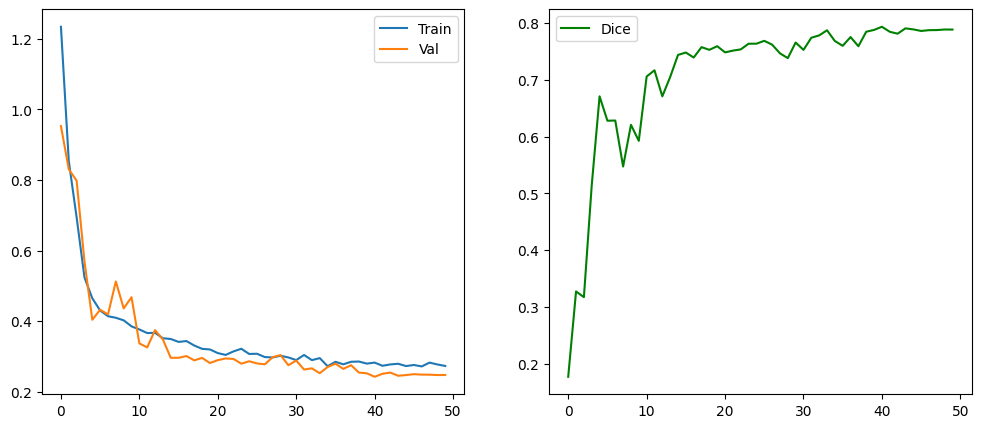

In [ ]:
# =============================================================================
# 🚀 TRAINING LOOP
# =============================================================================
GPU_COUNT = torch.cuda.device_count()
if GPU_COUNT > 1:
    print("Multiple GPUs detected; using device 0 only.")

criterion = DiceCELoss(to_onehot_y=True, softmax=True, include_background=False)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda')) 
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Resume Logic
history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'epochs': []}
start_epoch, best_dice = 0, 0.0
last_ckpt = os.path.join(CHECKPOINT_DIR, "last.pth")
history_path = os.path.join(RESULTS_DIR, "log.json")

if os.path.exists(last_ckpt):
    print("🔄 Resuming from checkpoint...")
    ckpt = torch.load(last_ckpt)
    
    # Load State Dict handling DataParallel wrapper
    sd = ckpt['model_state_dict']
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(sd)
    else: 
        # Fix if resuming non-parallel on parallel or vice-versa
        new_sd = {k.replace('module.', ''): v for k, v in sd.items()}
        model.load_state_dict(new_sd, strict=False)
        
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scaler.load_state_dict(ckpt['scaler_state_dict'])
    start_epoch = ckpt['epoch'] + 1
    best_dice = ckpt['best_dice']
    if os.path.exists(history_path):
        with open(history_path, 'r') as f: history = json.load(f)

print(f"🚀 Training starting at Epoch {start_epoch+1}...")
START_TIME = time.time()

for epoch in range(start_epoch, NUM_EPOCHS):
    if time.time() - START_TIME > MAX_RUNTIME:
        print("🛑 Time limit reached."); break
        
    model.train()
    ep_loss = 0
    
    # Train Step
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Ep {epoch+1}")
    for i, batch in pbar:
        img, lbl = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
        
        # 1. Clear Gradients (Optimizer update preparation)
        optimizer.zero_grad()
        
        # 2. Forward Pass (How inputs produce predictions)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
            pred = model(img)
            # 3. Loss Computation (How errors are calculated)
            loss = criterion(pred, lbl)
        
        # 4. Backpropagation (How gradients are computed)
        scaler.scale(loss).backward()
        
        #5. Optimizer Update (How model weights are updated)
        scaler.step(optimizer)
        scaler.update()
        
        ep_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # Val Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Val"):
            img, lbl = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                pred = model(img)
                val_loss += criterion(pred, lbl).item()
            
            p = [AsDiscrete(argmax=True, to_onehot=4)(i) for i in pred]
            t = [AsDiscrete(to_onehot=4)(i) for i in lbl]
            dice_metric(y_pred=p, y=t)
            
    # Stats
    stats = {
        'train_loss': ep_loss / len(train_loader),
        'val_loss': val_loss / len(val_loader),
        'val_dice': dice_metric.aggregate().item()
    }
    dice_metric.reset()
    
    # Update History & Log
    history['epochs'].append(epoch+1)
    for k, v in stats.items(): history[k].append(v)
    with open(history_path, 'w') as f: json.dump(history, f)
    
    print(f"   Stats: Train={stats['train_loss']:.4f} | Val={stats['val_loss']:.4f} | Dice={stats['val_dice']:.4f}")
    
    # Save State
    state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    ckpt = {
        'epoch': epoch, 'model_state_dict': state,
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(), 'best_dice': best_dice
    }
    torch.save(ckpt, last_ckpt)
    
    if stats['val_dice'] > best_dice:
        print(f"   ⭐ New Best! {best_dice:.4f} -> {stats['val_dice']:.4f}")
        best_dice = stats['val_dice']
        torch.save(state, os.path.join(BEST_MODEL_DIR, "best_model.pth"))
        
    scheduler.step()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history['val_dice'], label='Dice', color='green'); plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, "training_curves.png"))
plt.show()

# 📝 BraTSMamba Evaluation 

---

Content :

- Evaluation code

In [ ]:
# =============================================================================
# 🏆 EVALUATION & METRICS
# =============================================================================
def get_brats_regions(tensor_oh):
    """Converts One-Hot (BG, NCR, ED, ET) -> (WT, TC, ET)"""
    wt = torch.sum(tensor_oh[:, 1:4, ...], dim=1, keepdim=True) > 0
    tc = (tensor_oh[:, 1:2, ...] + tensor_oh[:, 3:4, ...]) > 0
    et = tensor_oh[:, 3:4, ...] > 0
    return torch.cat([wt, tc, et], dim=1).float()

def evaluate_model(model, loader):
    model.eval()
    dice_metric = DiceMetric(include_background=True, reduction="mean_batch")
    hd95_metric = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="mean_batch")
    post_pred = AsDiscrete(argmax=True, to_onehot=4)
    post_label = AsDiscrete(to_onehot=4)
    
    print("🔍 Starting Final Evaluation...")
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            img, lbl = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            pred = model(img)
            
            # Post-process
            pred_oh = torch.stack([post_pred(x) for x in pred])
            lbl_oh = torch.stack([post_label(x) for x in lbl])
            
            # Convert to BraTS Regions
            pred_reg = get_brats_regions(pred_oh)
            lbl_reg = get_brats_regions(lbl_oh)
            
            dice_metric(y_pred=pred_reg, y=lbl_reg)
            hd95_metric(y_pred=pred_reg, y=lbl_reg)
            
            # Visualize First Batch
            if i == 0:
                visualize_prediction(img[0], lbl[0], pred[0], 
                                     os.path.join(RESULTS_DIR, "best_pred.png"))

    # Aggregate
    dice = dice_metric.aggregate().cpu().numpy()
    hd95 = hd95_metric.aggregate().cpu().numpy()
    
    df = pd.DataFrame({
        "Region": ["Whole Tumor (WT)", "Tumor Core (TC)", "Enhancing Tumor (ET)"],
        "Dice (DSC) ↑": dice,
        "HD95 (mm) ↓": hd95,
        "Mean Dice": [dice.mean()] * 3
    })
    
    csv_path = os.path.join(RESULTS_DIR, "final_metrics.csv")
    df.to_csv(csv_path, index=False)
    print("\n🏆 FINAL SCORES:"); print(df.to_string(index=False, float_format="%.4f"))

def visualize_prediction(img, lbl, pred, save_path):
    """Helper to visualize input vs prediction."""
    vol = lbl.sum(dim=(0,1,2)); idx = torch.argmax(vol).item()
    if vol.max() == 0: idx = img.shape[2] // 2
    
    im = img[2, :, :, idx].cpu().numpy()
    gt = torch.argmax(lbl, dim=0)[:, :, idx].cpu().numpy()
    pr = torch.argmax(pred, dim=0)[:, :, idx].cpu().numpy()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(im, cmap='gray'); ax[0].set_title("Input (T2)")
    ax[1].imshow(gt, cmap='jet', vmin=0, vmax=3); ax[1].set_title("GT")
    ax[2].imshow(pr, cmap='jet', vmin=0, vmax=3); ax[2].set_title("Pred")
    plt.savefig(save_path); plt.close()

# Load Best & Run
best_path = os.path.join(BEST_MODEL_DIR, "best_model.pth")
if os.path.exists(best_path):
    print(f"📂 Loading Best Model: {best_path}")
    sd = torch.load(best_path)
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(sd)
    else: model.load_state_dict(sd)
    evaluate_model(model, val_loader)
else:
    print("⚠️ No best model found.")

📂 Loading Best Model: /storage2/ChangeDetection/NSST-mamba/mamba_decoder/UrbanMamba/outputs/bratsmamba/best_model/best_model.pth
🔍 Starting Final Evaluation...


100%|██████████| 250/250 [02:53<00:00,  1.44it/s]


🏆 FINAL SCORES:
              Region  Dice (DSC) ↑  HD95 (mm) ↓  Mean Dice
    Whole Tumor (WT)        0.8933       9.1794     0.8706
     Tumor Core (TC)        0.8742       8.6031     0.8706
Enhancing Tumor (ET)        0.8443       7.0057     0.8706


# 📊 Benchmark Model Training

---

Content :

- Benchmark Models Overview
- Referred Sources
- Trainer Function
- 3D U-Net Training
  - Configurations
  - Data Loaders
  - Training Loop
- UNETR Training
  - Configurations
  - Data Loaders
  - Training Loop
- Swin UNETR Training
  - Configurations
  - Data Loaders
  - Training Loop

This benchmarking script is designed . It re-initializes the data loaders using the robust method we just fixed, then trains and evaluates three distinct architectures: 3D U-Net (nnU-Net analog), UNETR (Transformer baseline), and Swin UNETR.

Benchmarking Strategy

* **3D U-Net (nnU-Net Analog)**: The gold standard CNN baseline. We use a residual 3D U-Net configuration similar to the self-configuring method described in [1].


* **UNETR**: A standard Vision Transformer (ViT) encoder with a CNN decoder, serving as our "Analogous Transformer" baseline.[2]


* **Swin UNETR**: A hierarchical Swin Transformer encoder that addresses the fixed-scale limitations of standard ViTs, as detailed in Hatamizadeh et al.[3]

> Note: SegMamba is excluded to avoid the heavy installation overhead of mamba-ssm(This also a SOTA mamba architecture, but due to importing overhead we decided to benchmark with simple CNN, and Transfomer methods)

## Referred Sources


[1]O. Içek, A. Abdulkadir, S. Lienkamp, T. Brox, and O. Ronneberger, “3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation.” Available: https://arxiv.org/pdf/1606.06650

[2]A. Nvidia et al., “UNETR: Transformers for 3D Medical Image Segmentation.” Available: https://arxiv.org/pdf/2103.10504

[3]A. Hatamizadeh, V. Nath, Y. Tang, D. Yang, H. Roth, and D. Xu, “Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images.” Available: https://arxiv.org/pdf/2201.01266
‌
‌



## Trainer Function

In [ ]:
# =============================================================================
# 🚀 BENCHMARK TRAINING ENGINE
# =============================================================================

# benchmark model path
BENCH_PATH = os.path.join(ARTIFACTS_DIR, "benchmarks")
if not os.path.exists(BENCH_PATH):
    os.makedirs(BENCH_PATH)

def train_benchmark_model(model_name, model, train_loader, val_loader, device):
    print(f"\n🚀 STARTING BENCHMARK: {model_name}")
    print("=" * 60)
    
    save_path = os.path.join(BENCH_PATH, f"{model_name}_best.pth")
    criterion = DiceCELoss(to_onehot_y=True, softmax=True, include_background=False)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    
    scaler = GradScaler('cuda')
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    
    best_dice = 0.0
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0
        
        # Training Step
        pbar = tqdm(train_loader, desc=f"{model_name} Ep {epoch+1}/{NUM_EPOCHS}", leave=False)
        for batch in pbar:
            imgs, lbls = batch["image"].to(device), batch["label"].to(device)
            
            optimizer.zero_grad()
            with autocast('cuda'):
                preds = model(imgs)
                loss = criterion(preds, lbls)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
            
        # Validation Step (Sliding Window)
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                imgs, lbls = batch["image"].to(device), batch["label"].to(device)
                with autocast('cuda'):
                    # Sliding window is mandatory for Batch Size 1 variable inputs
                    preds = sliding_window_inference(imgs, IMG_SIZE, 4, model)
                
                p = [AsDiscrete(argmax=True, to_onehot=4)(i) for i in preds]
                t = [AsDiscrete(to_onehot=4)(i) for i in lbls]
                dice_metric(y_pred=p, y=t)
        
        # Stats
        avg_dice = dice_metric.aggregate().item()
        dice_metric.reset()
        
        print(f"   Ep {epoch+1}: Loss={train_loss/len(train_loader):.4f} | Val Dice={avg_dice:.4f}")
        
        # Save Best
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), save_path)
            print(f"   ⭐ New Best Saved!")
            
    print(f"✅ Finished {model_name}. Best Dice: {best_dice:.4f}\n")
    return best_dice, save_path

# --- RUN EXPERIMENTS ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

## 3D U-Net Training

In [ ]:
# configs for 3D U-Net

# Dataset Limits (Set N_SAMPLES to None for full dataset)
N_SAMPLES_3DUNET = None     
VAL_SPLIT_3DUNET = 0.2

# Training Hyperparameters for BraTSMamba
IMG_SIZE_3DUNET = (128, 128, 128)
BATCH_SIZE_TRAIN_3DUNET = 4   # Effective batch size = 8 (on 2 GPUs)
BATCH_SIZE_VAL_3DUNET = 1     # MUST be 1 to handle variable image sizes
NUM_WORKERS_3DUNET = 8        # High worker count for efficient lazy loading
NUM_EPOCHS_3DUNET = 50
LEARNING_RATE_3DUNET = 3e-4
MAX_RUNTIME_3DUNET = 12 * 3600 

### Data Loader

In [ ]:
print("⏳ Initializing Loaders (Lazy Loading)...")
# Split Data
val_count = int(len(all_files) * VAL_SPLIT_3DUNET)
val_count = max(1, val_count) # Ensure at least 1 val sample
train_files, val_files = all_files[val_count:], all_files[:val_count]

print(f"📊 Dataset Split: Train={len(train_files)} | Val={len(val_files)}")
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN_3DUNET, shuffle=True, 
    num_workers=NUM_WORKERS_3DUNET, pin_memory=True
)
# Note: Batch Size 1 is critical for Val to handle variable volume sizes
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_VAL_3DUNET, shuffle=False, 
    num_workers=NUM_WORKERS_3DUNET, pin_memory=True
)
print("✅ Loaders Ready.")

### Model Initialization

In [ ]:
# 1. 3D U-Net (Baseline)
model_unet = UNet(
    spatial_dims=3, in_channels=4, out_channels=4, 
    channels=(32, 64, 128, 256, 512), strides=(2, 2, 2, 2), 
    num_res_units=2, norm="instance"
).to(DEVICE)
d_unet, p_unet = train_benchmark_model("3D_UNet", model_unet, train_loader, val_loader, DEVICE)
results["3D_UNet"] = {"Path": p_unet, "Paper": "3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation."}
del model_unet; torch.cuda.empty_cache()

## UNETR Training

In [ ]:
# configs for 3D U-Net

# Dataset Limits (Set N_SAMPLES to None for full dataset)
N_SAMPLES_UNETR = None     
VAL_SPLIT_UNETR = 0.2

# Training Hyperparameters for BraTSMamba
IMG_SIZE_UNETR = (128, 128, 128)
BATCH_SIZE_TRAIN_UNETR = 4   # Effective batch size = 8 (on 2 GPUs)
BATCH_SIZE_VAL_UNETR = 1     # MUST be 1 to handle variable image sizes
NUM_WORKERS_UNETR = 8        # High worker count for efficient lazy loading
NUM_EPOCHS_UNETR = 50
LEARNING_RATE_UNETR = 3e-4
MAX_RUNTIME_UNETR = 12 * 3600 

### Data Loading

In [ ]:
print("⏳ Initializing Loaders (Lazy Loading)...")
# Split Data
val_count = int(len(all_files) * VAL_SPLIT_UNETR)
val_count = max(1, val_count) # Ensure at least 1 val sample
train_files, val_files = all_files[val_count:], all_files[:val_count]

print(f"📊 Dataset Split: Train={len(train_files)} | Val={len(val_files)}")
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN_UNETR, shuffle=True, 
    num_workers=NUM_WORKERS_UNETR, pin_memory=True
)
# Note: Batch Size 1 is critical for Val to handle variable volume sizes
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_VAL_UNETR, shuffle=False, 
    num_workers=NUM_WORKERS_UNETR, pin_memory=True
)
print("✅ Loaders Ready.")

### Model Initialization

In [ ]:
# 2. UNETR (Transformer)
model_unetr = UNETR(
    in_channels=4, 
    out_channels=4, 
    img_size=Config.IMG_SIZE, 
    feature_size=16, 
    hidden_size=768, 
    mlp_dim=3072, 
    num_heads=12, 
    norm_name="instance", 
    res_block=True
).to(DEVICE)

d_unetr, p_unetr = train_benchmark_model("UNETR", model_unetr, train_loader, val_loader, DEVICE)
results["UNETR"] = {"Path": p_unetr, "Paper": "Hatamizadeh et al. (2022)"}
del model_unetr; torch.cuda.empty_cache()

## Swin UNETR Training

In [ ]:
# configs for 3D U-Net

# Dataset Limits (Set N_SAMPLES to None for full dataset)
N_SAMPLES_SWIN = None     
VAL_SPLIT_SWIN = 0.2

# Training Hyperparameters for BraTSMamba
IMG_SIZE_SWIN = (128, 128, 128)
BATCH_SIZE_TRAIN_SWIN = 4   # Effective batch size = 8 (on 2 GPUs)
BATCH_SIZE_VAL_SWIN = 1     # MUST be 1 to handle variable image sizes
NUM_WORKERS_SWIN = 8        # High worker count for efficient lazy loading
NUM_EPOCHS_SWIN = 50
LEARNING_RATE_SWIN = 3e-4
MAX_RUNTIME_SWIN = 12 * 3600 

### Data Loading

In [ ]:
print("⏳ Initializing Loaders (Lazy Loading)...")
# Split Data
val_count = int(len(all_files) * VAL_SPLIT_SWIN)
val_count = max(1, val_count) # Ensure at least 1 val sample
train_files, val_files = all_files[val_count:], all_files[:val_count]

print(f"📊 Dataset Split: Train={len(train_files)} | Val={len(val_files)}")
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN_SWIN, shuffle=True, 
    num_workers=NUM_WORKERS_SWIN, pin_memory=True
)
# Note: Batch Size 1 is critical for Val to handle variable volume sizes
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE_VAL_SWIN, shuffle=False, 
    num_workers=NUM_WORKERS_SWIN, pin_memory=True
)
print("✅ Loaders Ready.")

### Model Initialization

In [ ]:
# 3. Swin UNETR (SOTA Transformer)

model_swin = SwinUNETR(
    in_channels=4, 
    out_channels=4, 
    feature_size=24, 
    use_checkpoint=True
).to(DEVICE)

d_swin, p_swin = train_benchmark_model("SwinUNETR", model_swin, train_loader, val_loader, DEVICE)
results["SwinUNETR"] = {"Path": p_swin, "Paper": "Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images."}

# 🏆 Benchmark model evaluation

---

Content :

- Benchmark Model Evaluation Code

In [ ]:
# =============================================================================
# 🏆 FINAL EVALUATION & JSON EXPORT
# =============================================================================
def get_brats_regions(tensor_oh):
    """Converts One-Hot -> BraTS Regions (WT, TC, ET)"""
    wt = torch.sum(tensor_oh[:, 1:4, ...], dim=1, keepdim=True) > 0
    tc = (tensor_oh[:, 1:2, ...] + tensor_oh[:, 3:4, ...]) > 0
    et = tensor_oh[:, 3:4, ...] > 0
    return torch.cat([wt, tc, et], dim=1).float()

def final_evaluation(results_dict, loader, device):
    final_json = []
    
    metric_dice = DiceMetric(include_background=True, reduction="mean_batch")
    metric_hd95 = HausdorffDistanceMetric(include_background=True, percentile=95, reduction="mean_batch")
    post_pred = AsDiscrete(argmax=True, to_onehot=4)
    post_label = AsDiscrete(to_onehot=4)

    for model_name, info in results_dict.items():
        print(f"📊 Evaluating Best {model_name}...")
        
        # FIXED: Robust String Matching for Model Re-initialization
        if model_name == "3D_UNet":
            model = UNet(spatial_dims=3, in_channels=4, out_channels=4, channels=(32, 64, 128, 256, 512), strides=(2, 2, 2, 2), num_res_units=2, norm="instance").to(device)
        elif model_name == "UNETR":
            model = UNETR(in_channels=4, out_channels=4, img_size=Config.IMG_SIZE, feature_size=16, hidden_size=768, mlp_dim=3072, num_heads=12, pos_embed="perceptron", norm_name="instance", res_block=True).to(device)
        elif model_name == "SwinUNETR":
            model = SwinUNETR(img_size=Config.IMG_SIZE, in_channels=4, out_channels=4, feature_size=24, use_checkpoint=True).to(device)
        else:
            print(f"⚠️ Unknown model name {model_name}, skipping.")
            continue
            
        model.load_state_dict(torch.load(info["Path"]))
        model.eval()
        
        with torch.no_grad():
            for batch in tqdm(loader, desc=f"Eval {model_name}"):
                imgs, lbls = batch["image"].to(device), batch["label"].to(device)
                
                # Sliding Window Inference
                logits = sliding_window_inference(imgs, IMG_SIZE, 4, model)
                
                preds_reg = get_brats_regions(torch.stack([post_pred(i) for i in logits]))
                lbls_reg = get_brats_regions(torch.stack([post_label(i) for i in lbls]))
                
                metric_dice(y_pred=preds_reg, y=lbls_reg)
                metric_hd95(y_pred=preds_reg, y=lbls_reg)
        
        # Aggregation
        dice_scores = metric_dice.aggregate().cpu().numpy()
        hd95_scores = metric_hd95.aggregate().cpu().numpy()
        metric_dice.reset()
        metric_hd95.reset()
        
        entry = {
            "Model": model_name,
            "Citation": info["Paper"],
            "Whole_Tumor_Dice": float(dice_scores[0]),
            "Tumor_Core_Dice": float(dice_scores[1]),
            "Enhancing_Tumor_Dice": float(dice_scores[2]),
            "Whole_Tumor_HD95": float(hd95_scores[0]),
            "Tumor_Core_HD95": float(hd95_scores[1]),
            "Enhancing_Tumor_HD95": float(hd95_scores[2]),
            "Mean_Dice": float(dice_scores.mean())
        }
        final_json.append(entry)
        
        del model
        torch.cuda.empty_cache()

    return final_json

# Execute Eval
benchmark_data = final_evaluation(results, val_loader, DEVICE)

# Save Results
json_path = os.path.join(ARTIFACTS_DIR, "final_benchmark_results.json")
with open(json_path, "w") as f:
    json.dump(benchmark_data, f, indent=4)

print(f"\n✅ Benchmarking Complete. Results saved to: {json_path}")
print(json.dumps(benchmark_data, indent=2))

# 🚀 Conclusion & Real-World Deployment Strategy

--- 

Content:

- Deployment Scenario
- Limitations  
- Future Work: BratMamba v2 (Proposed Architecture)

## Deployment Scenario

To integrate **BraTSMamba** into a clinical workflow, we propose a "Human-in-the-Loop" AI assistance system:
1.  **Input:** MRI Technician uploads raw NIfTI sequences (T1, T2, FLAIR) to a hospital PACS server.
2.  **Inference:** The model runs on a dedicated on-premise GPU server (ensuring patient data privacy/HIPAA compliance).
3.  **Output:** The model generates a candidate segmentation mask.
4.  **Review:** A Radiologist reviews the 3D mask, makes minor adjustments if necessary, and approves it for the surgical planning system.


## Limitations

*   **Domain Shift:** The model is trained on BraTS (pre-operative) data. It may struggle with post-operative scans containing surgical cavities or metal artifacts unless fine-tuned.
  
*   **Computational Cost:** While Mamba is efficient ($O(N)$), processing 3D volumes still requires significant GPU memory, limiting deployment on standard clinical desktops without quantization.




## Future Work: BratMamba v2 (Proposed Architecture)

We have theoretically designed and prototyped a more advanced iteration, **BratMamba v2**, which addresses the unidirectional bias of standard Mamba blocks. While the current implementation flattens 3D volumes into 1D sequences, potentially losing spatial coherence, v2 introduces **3D Selective Scan (SS3D)**.

**Key Architectural Innovations:**

1.  **SS3D (3D Selective Scan):** Inspired by VMamba's 2D scanning, this module scans the 3D volume in **four distinct directions** (Forward, Backward, Transposed-Forward, Transposed-Backward). This ensures that every voxel receives contextual information from all spatial neighbors, not just those preceding it in a flattened sequence.
   
2.  **GSC (Gated Spatial Convolution):** A specialized block that injects inductive biases (local spatial awareness) before the Mamba layer, ensuring the model captures fine-grained texture details like tumor boundaries better than pure SSMs.
   
3.  **FUE (Feature Uncertainty Estimation):** A novel module integrated into the skip connections. It calculates the entropy of feature maps to estimate uncertainty, effectively filtering out "noisy" or ambiguous features before they merge with the decoder.

**Why it's Superior:**

Unlike **SegMamba** or **UMamba**, which often rely on standard Mamba blocks, or **Transformers** which suffer from quadratic complexity, BratMamba v2 offers a truly omnidirectional global receptive field with linear complexity. The FUE module specifically targets the "false positive" problem common in Edema segmentation.

**Current Barrier:**

The 4-directional scanning mechanism quadruples the intermediate state memory. Training this architecture requires approximately **60GB VRAM** (e.g., NVIDIA A100 80GB), exceeding the resources available for this hackathon. 